In [96]:
import os, sys
import numpy as np
import pandas as pd
import SimpleITK as sitk
from scipy import ndimage as ndi
from skimage import filters
from skimage import measure
import skimage
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
import SimpleITK as sitk

# ref https://gist.github.com/pangyuteng/7f54dbfcd67fb9d43a85f8c6818fca7b
def imread(fpath):
    if os.path.isdir(fpath):
        dicom_names = [os.path.join(fpath,x) for x in os.listdir(fpath)]
        mylist = []
        for x in dicom_names:
            ds = pydicom.dcmread(x)
            mylist.append( (ds.InstanceNumber,x))
        
        dicom_names = [x[1] for x in sorted(mylist,key=lambda x: x[0])]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()
    return img

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)

# ref https://gist.github.com/mrajchl/ccbd5ed12eb68e0c1afc5da116af614a
def resample_img(itk_image,origin,direction):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    out_spacing=[1.0, 1.0, 1.0]
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(direction)
    resample.SetOutputOrigin(origin)
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    sampler = None
    if sampler == 'nearest':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


In [100]:
import os
import requests
local_filename = 'img.zip'
if not os.path.exists(local_filename):
    uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075"
    r=requests.get(f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={uid}")
    if r.status_code == 200:
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    del r

In [101]:
# !mkdir -p img && unzip img.zip -d img

In [159]:
itk_image = imread('img')

(0.609375, 0.609375, 1.25) (-146.7, -152.2, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (512, 512, 241)


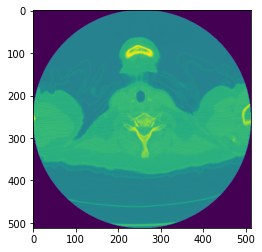

In [161]:
arr = sitk.GetArrayFromImage(itk_image)    
spacing = itk_image.GetSpacing()
origin = itk_image.GetOrigin()
direction = itk_image.GetDirection()
size = itk_image.GetSize()

print(spacing,origin,direction,size)

plt.imshow(arr[0,:,:].squeeze())

In [209]:
roi_image = imread('rof.nii.gz')
arr = sitk.GetArrayFromImage(roi_image)    
print(np.sum(arr))

1525


In [ ]:
itk_image = imread('image.nii.gz')
roi_image = imread('rof.nii.gz')

spacing = itk_image.GetSpacing()
spacing = (1,1,1)
origin = itk_image.GetOrigin()
direction = itk_image.GetDirection()
size = itk_image.GetSize()

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkBSpline)

new_img = resample.Execute(itk_image)
arr = sitk.GetArrayFromImage(new_img)

spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)

resample.SetInterpolator(sitk.sitkNearestNeighbor)
new_roi = resample.Execute(roi_image)

spacing = new_roi.GetSpacing()
origin = new_roi.GetOrigin()
direction = new_roi.GetDirection()
size = new_roi.GetSize()

print(spacing,origin,direction,size)


In [ ]:
arr = sitk.GetArrayFromImage(new_roi).astype(int)
_zs,_xs,_ys = np.where(arr==1)
ps = []
for x,y,z in zip(_xs,_ys,_zs):
    p = new_roi.TransformContinuousIndexToPhysicalPoint((float(x),float(y),float(z)))
    ps.append(p)
ps = np.array(ps)
print(ps.shape)

solution:
1.575928 x + -0.075292 y + 1021.989305 = z


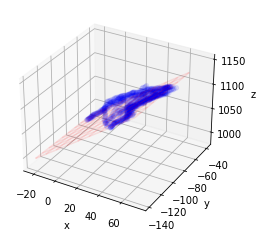

In [337]:
xs = ps[:,0]
ys = ps[:,1]
zs = ps[:,2]

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

print("solution:")
print("%f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors:")
#print(errors)
#print("residual:")
#print(residual)

# plot plane
X,Y = np.meshgrid(np.arange(np.min(xs),np.max(xs),10),
                  np.arange(np.min(ys),np.max(ys),10))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
        
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b',alpha=0.05)

ax.plot_wireframe(X,Y,Z, color='r',alpha=0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [338]:
print("%f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))

1.575928 x + -0.075292 y + 1021.989305 = z


In [339]:
# https://web.ma.utexas.edu/users/m408m/Display12-5-4.shtml
z_vec = np.array([fit[0,0], fit[1,0], -1])
z_vec = z_vec / (np.linalg.norm(z_vec) + 1e-16)
print(z_vec)

[ 0.8436694  -0.04030734 -0.53534779]


In [340]:
np.min(X),np.max(X),np.min(Y),np.max(Y)

(-22.66015625, 67.33984375, -138.16015625, -48.16015625)

In [329]:
c00 = (X[0,0],Y[0,0],Z[0,0])
c10 = (X[-1,0],Y[-1,0],Z[-1,0])
c01 = (X[0,-1],Y[0,-1],Z[0,-1])
origin = c00
print(origin)
x_vec = np.array(c00)-np.array(c10)
x_vec = x_vec / (np.linalg.norm(x_vec) + 1e-16)
y_vec = np.array(c00)-np.array(c01)
y_vec = y_vec / (np.linalg.norm(y_vec) + 1e-16)

print(x_vec)
print(y_vec)
z_vec = np.cross(x_vec,y_vec)
print(z_vec)

direction = tuple(x_vec)+tuple(y_vec)+tuple(z_vec)

xsize = int(np.sqrt(np.sum(np.array(c00)-np.array(c01))**2))
ysize = int(np.sqrt(np.sum(np.array(c00)-np.array(c10))**2))

origin = np.array(c00)-np.array([0,0,-5])
origin = tuple(list(origin))
spacing = (1,1,1)
zsize = 1
size = (xsize,ysize,zsize)
print(size)


(-22.66015625, -138.16015625, 996.7687861531613)
[ 0.         -0.98876486  0.1494793 ]
[-0.51599654  0.         -0.85659067]
[ 0.84696675 -0.0771308  -0.51019924]
(239, 76, 1)


(1.0, 1.0, 1.0) (-22.66015625, -138.16015625, 1001.7687861531613) (0.0, -0.9887648550204214, 0.14947930116389066, -0.515996540221195, 0.0, -0.8565906668180296, 0.8469667464881752, -0.07713080223524962, -0.5101992442828489) (239, 76, 1)
(1.0, 1.0, 1.0) (-22.66015625, -138.16015625, 1001.7687861531613) (0.0, -0.9887648550204214, 0.14947930116389066, -0.515996540221195, 0.0, -0.8565906668180296, 0.8469667464881752, -0.07713080223524962, -0.5101992442828489) (239, 76, 1)


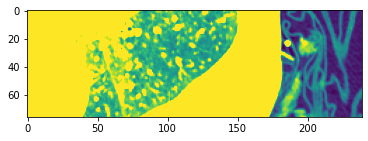

In [330]:

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
#resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
resample.SetDefaultPixelValue(-2000)
resample.SetInterpolator(sitk.sitkBSpline)
new_img = resample.Execute(itk_image)


arr = sitk.GetArrayFromImage(new_img)
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)

print(spacing,origin,direction,size)
for i in range(zsize):
    plt.figure(i)
    plt.imshow(arr[i,:,:].squeeze(),vmin=-1024,vmax=-700)

In [332]:
size = new_img.GetSize()
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()

arr=np.zeros(arr.shape)
img = sitk.GetImageFromArray(arr)
img.SetSpacing(spacing)
img.SetOrigin(origin)
img.SetDirection(direction)
writer = sitk.ImageFileWriter()    
writer.SetFileName('oblique.nii.gz')
writer.SetUseCompression(True)
writer.Execute(img)


(1.0, 1.0, 1.0) (-22.66015625, -138.16015625, 1001.7687861531613) (0.0, -0.9887648550204214, 0.14947930116389066, -0.515996540221195, 0.0, -0.8565906668180296, 0.8469667464881752, -0.07713080223524962, -0.5101992442828489) (239, 76, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


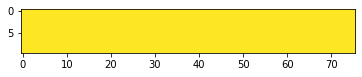

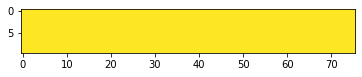

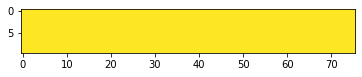

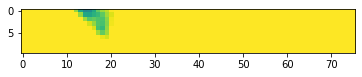

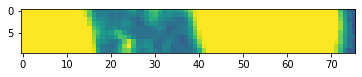

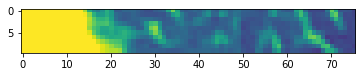

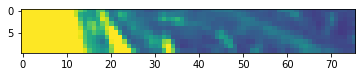

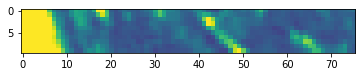

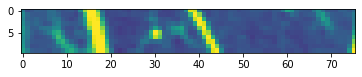

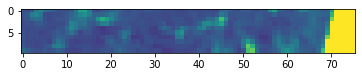

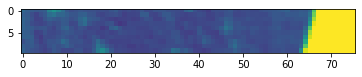

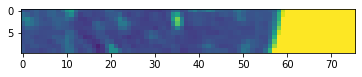

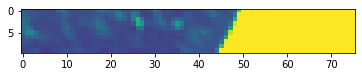

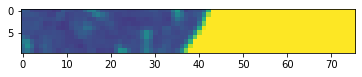

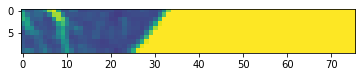

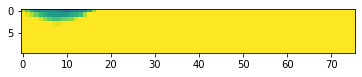

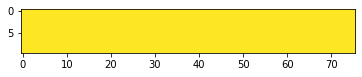

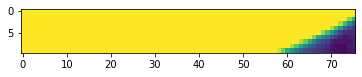

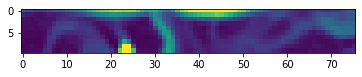

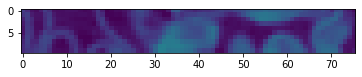

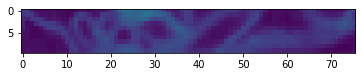

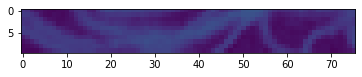

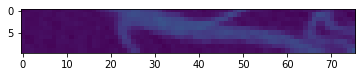

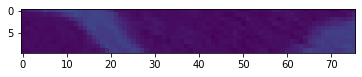

In [327]:
print(spacing,origin,direction,size)
for i in np.arange(0,arr.shape[2],10):
    plt.figure(i)
    plt.imshow(arr[:,:,i].squeeze(),vmin=-1024,vmax=-200)

(1.0, 1.0, 1.0) (-22.66015625, -138.16015625, 1001.7687861531613) (0.0, -0.9887648550204214, 0.14947930116389066, -0.515996540221195, 0.0, -0.8565906668180296, 0.8469667464881752, -0.07713080223524962, -0.5101992442828489) (239, 76, 10)


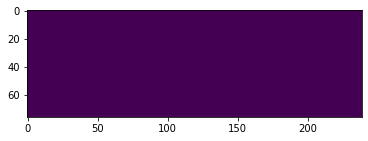

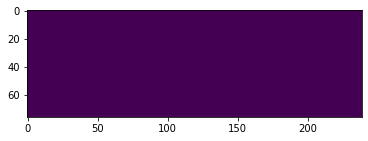

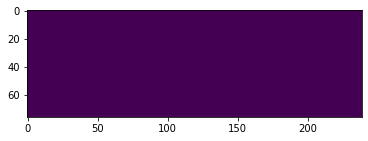

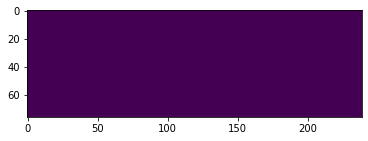

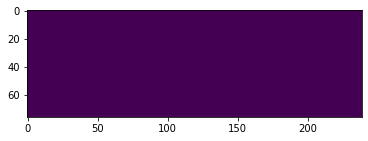

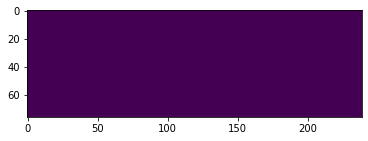

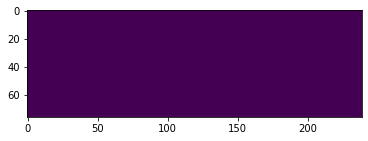

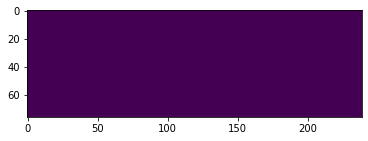

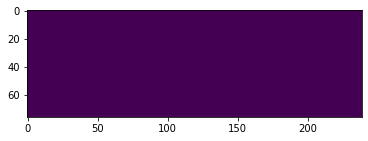

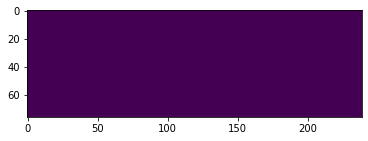

In [328]:

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(-1)
resample.SetInterpolator(sitk.sitkNearestNeighbor)
new_roi = resample.Execute(roi_image)

arr = sitk.GetArrayFromImage(new_roi)
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)
for i in range(zsize):
    plt.figure(i)
    plt.imshow(arr[i,:,:].squeeze())